In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.z_dim = z_dim

        self.fc = nn.Sequential(nn.Linear(z_dim, 7 * 7 * 256),nn.ReLU())
        self.reshape = nn.Unflatten(1, (256, 7, 7))
        self.deconv1 = nn.Sequential(nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),nn.BatchNorm2d(128),nn.ReLU())
        self.deconv2 = nn.Sequential(nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),nn.BatchNorm2d(64),nn.ReLU())
        self.deconv3 = nn.Sequential(nn.ConvTranspose2d(64, 1, kernel_size=3, stride=1, padding=1),nn.Tanh())

    def forward(self, z):
        x = self.fc(z)
        x = self.reshape(x)
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.deconv3(x)
        return x


z_dim = 100

generator = Generator(z_dim)

z = torch.randn((1, z_dim))
output = generator(z)
print(output.shape)

torch.Size([1, 1, 28, 28])


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(mnist_dataset, batch_size=64, shuffle=True)

In [ ]:
import matplotlib.pyplot as plt

def show_images(images):
    grid = torchvision.utils.make_grid(images, nrow=8, normalize=True)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0).detach().cpu().numpy(), cmap='gray')
    plt.axis('off')
    plt.show()

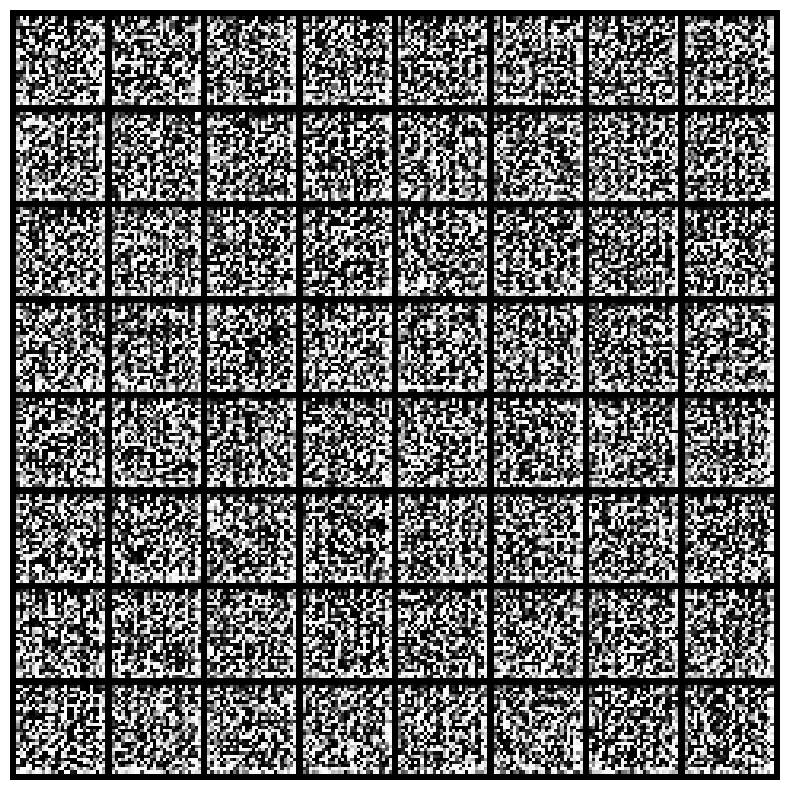

In [ ]:
z = torch.randn((64, z_dim))
fake_images = generator(z)
fake_images = fake_images.view(64, 1, 28, 28)
show_images(fake_images)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),nn.LeakyReLU(0.2))
        self.conv2 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),nn.BatchNorm2d(128),nn.LeakyReLU(0.2))
        self.conv3 = nn.Sequential(nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),nn.BatchNorm2d(256),nn.LeakyReLU(0.2))
        self.fc = nn.Sequential(nn.Linear(256 * 3 * 3, 1),nn.Sigmoid())

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(-1, 256 * 3 * 3)
        x = self.fc(x)
        return x


In [ ]:
criterion_discriminator = nn.BCELoss()

In [ ]:
discriminator = Discriminator().to(device)
generator = Generator(z_dim).to(device)

In [ ]:
import torch.optim as optim

optimizer_generator = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

Epoch [0/10], Batch Step [0/938], Discriminator Loss: 1.4722, Generator Loss: 0.8335


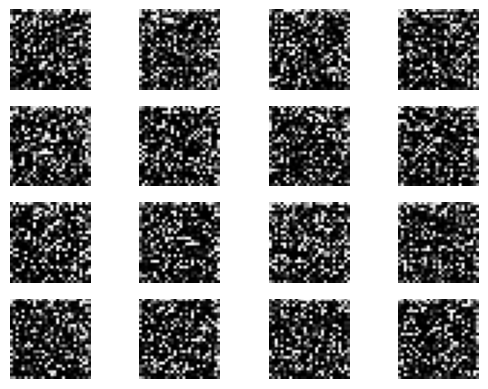

Epoch [0/10], Batch Step [500/938], Discriminator Loss: 0.1273, Generator Loss: 3.4764


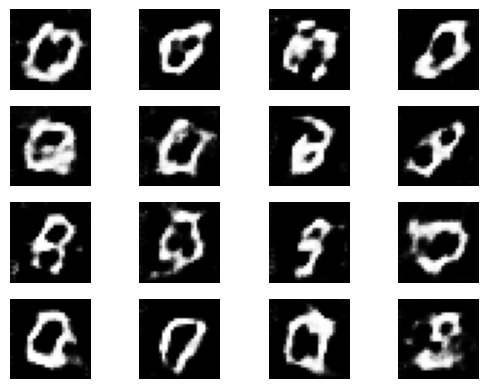

Epoch [1/10], Batch Step [0/938], Discriminator Loss: 0.8775, Generator Loss: 3.2595


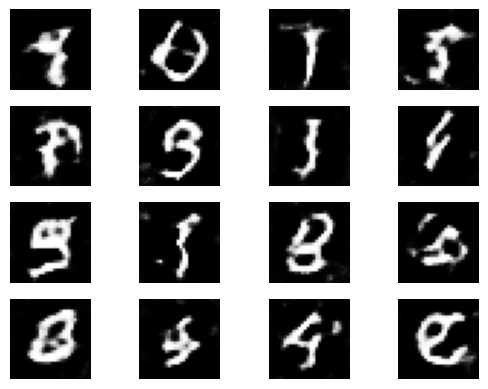

Epoch [1/10], Batch Step [500/938], Discriminator Loss: 0.0862, Generator Loss: 3.7734


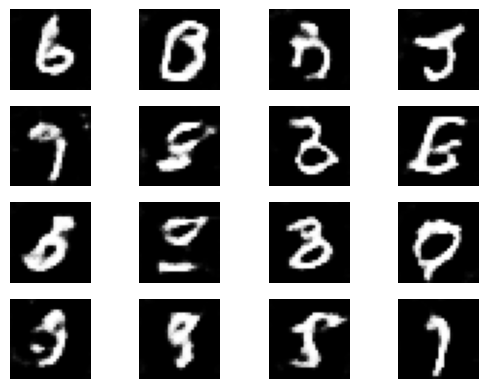

Epoch [2/10], Batch Step [0/938], Discriminator Loss: 0.2160, Generator Loss: 3.6048


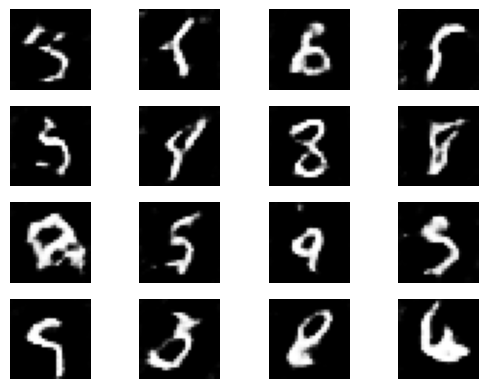

Epoch [2/10], Batch Step [500/938], Discriminator Loss: 0.2268, Generator Loss: 3.5337


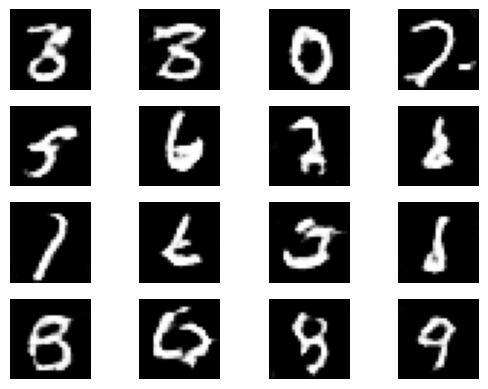

Epoch [3/10], Batch Step [0/938], Discriminator Loss: 0.1469, Generator Loss: 5.1843


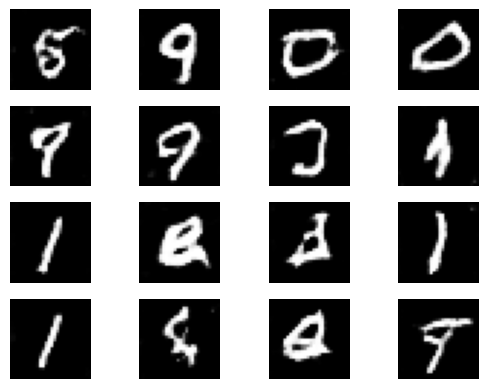

Epoch [3/10], Batch Step [500/938], Discriminator Loss: 0.2129, Generator Loss: 2.1665


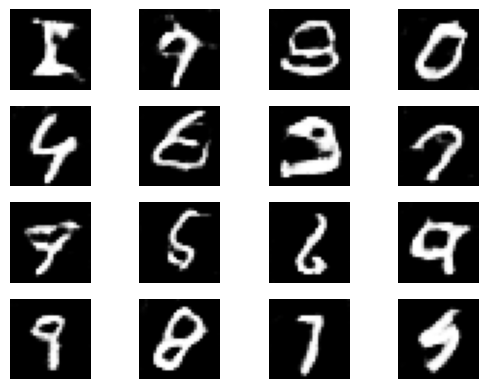

Epoch [4/10], Batch Step [0/938], Discriminator Loss: 0.1416, Generator Loss: 4.1165


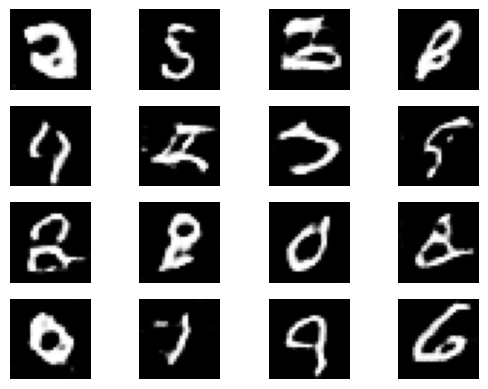

Epoch [4/10], Batch Step [500/938], Discriminator Loss: 0.1928, Generator Loss: 3.6356


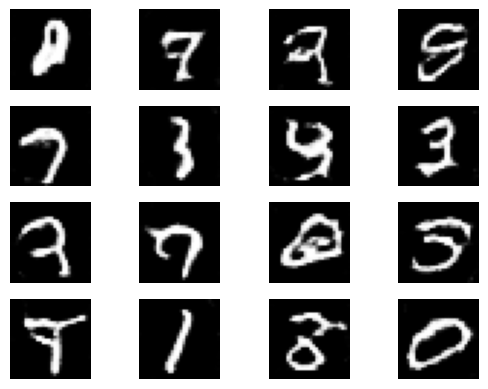

Epoch [5/10], Batch Step [0/938], Discriminator Loss: 0.1028, Generator Loss: 3.2613


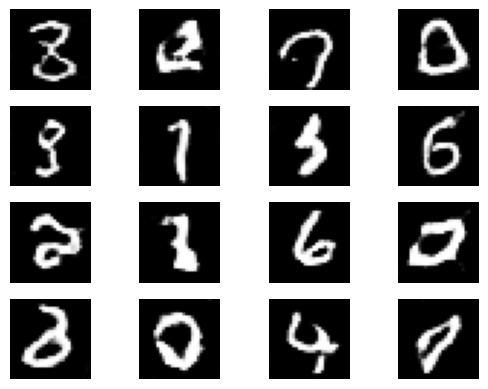

Epoch [5/10], Batch Step [500/938], Discriminator Loss: 0.1333, Generator Loss: 2.8262


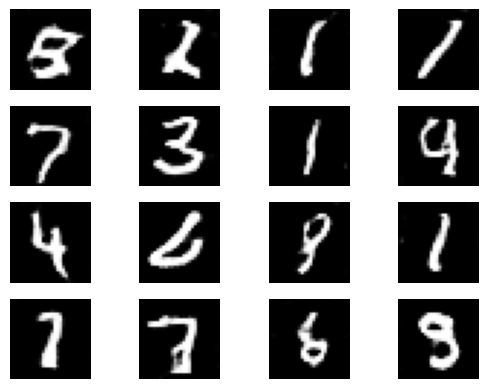

Epoch [6/10], Batch Step [0/938], Discriminator Loss: 0.0732, Generator Loss: 2.2027


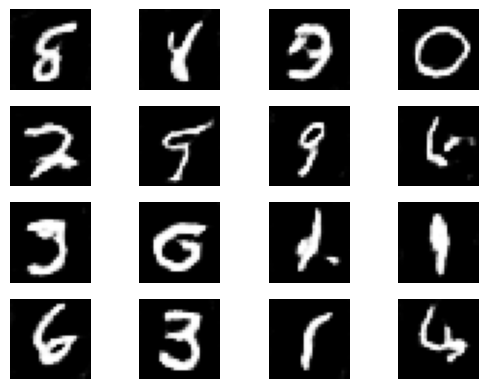

Epoch [6/10], Batch Step [500/938], Discriminator Loss: 0.0874, Generator Loss: 4.3499


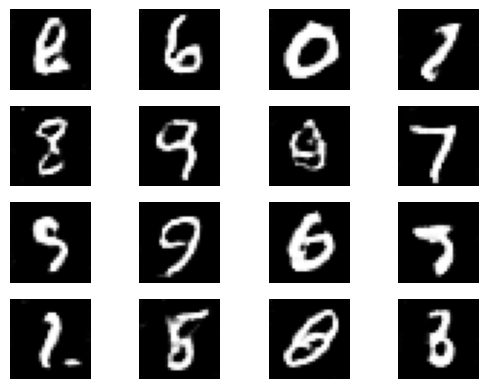

Epoch [7/10], Batch Step [0/938], Discriminator Loss: 0.4038, Generator Loss: 1.0673


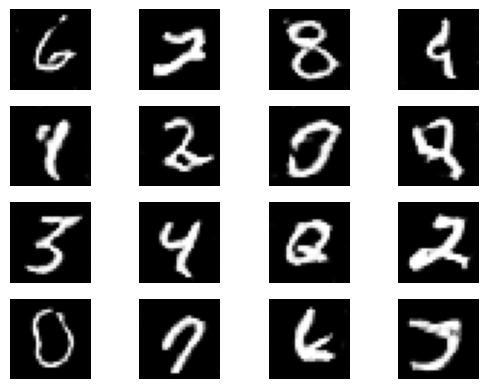

Epoch [7/10], Batch Step [500/938], Discriminator Loss: 0.1230, Generator Loss: 2.8228


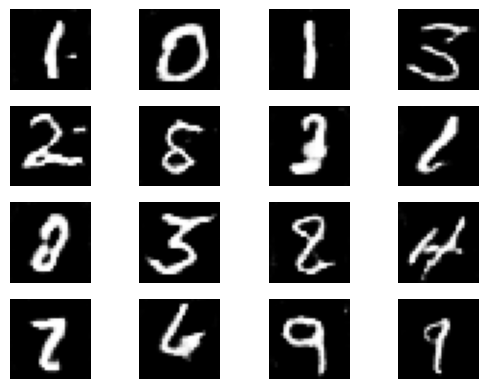

Epoch [8/10], Batch Step [0/938], Discriminator Loss: 0.0971, Generator Loss: 2.9955


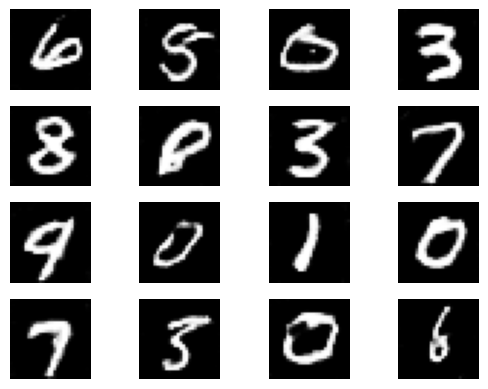

Epoch [8/10], Batch Step [500/938], Discriminator Loss: 0.1748, Generator Loss: 2.8958


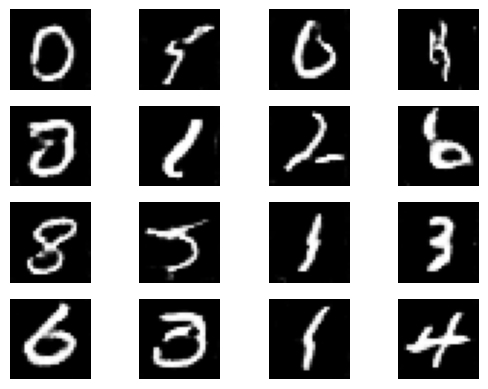

Epoch [9/10], Batch Step [0/938], Discriminator Loss: 0.2656, Generator Loss: 3.8528


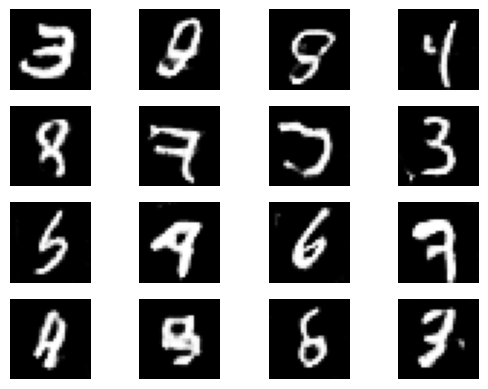

Epoch [9/10], Batch Step [500/938], Discriminator Loss: 0.0958, Generator Loss: 4.1963


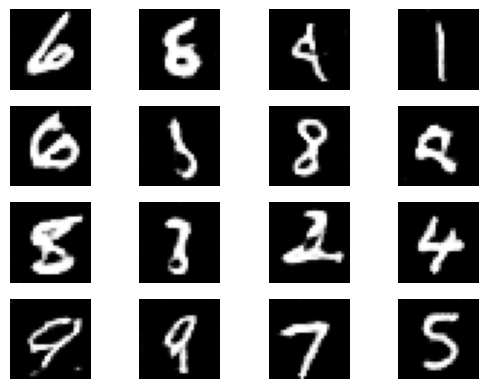

In [ ]:
n_epoch = 10
for epoch in range(n_epoch):
  for batch_idx, (real_images, _) in enumerate(dataloader):
    discriminator.zero_grad()
    real_images = real_images.to(device)
    real_outputs = discriminator(real_images)
    real_labels = torch.ones_like(real_outputs).to(device)
    real_loss = criterion_discriminator(real_outputs, real_labels)

    z = torch.randn((real_images.size(0), 100)).to(device)
    fake_images = generator(z)
    fake_outputs = discriminator(fake_images.detach())
    fake_labels = torch.zeros_like(fake_outputs).to(device)
    fake_loss = criterion_discriminator(fake_outputs, fake_labels)

    discriminator_loss = real_loss + fake_loss

    discriminator_loss.backward()
    optimizer_discriminator.step()

    generator.zero_grad()

    z = torch.randn((real_images.size(0), 100)).to(device)
    fake_images = generator(z)

    fake_outputs = discriminator(fake_images)
    real_labels = torch.ones_like(fake_outputs).to(device)

    generator_loss = criterion_discriminator(fake_outputs, real_labels)

    generator_loss.backward()
    optimizer_generator.step()

    if batch_idx % 500 == 0:
        print(f'Epoch [{epoch}/{n_epoch}], Batch Step [{batch_idx}/{len(dataloader)}], Discriminator Loss: {discriminator_loss.item():.4f}, Generator Loss: {generator_loss.item():.4f}')

        fig, axs = plt.subplots(4, 4)
        for i in range(4):
            for j in range(4):
                axs[i, j].imshow(fake_images[i * 4 + j].detach().cpu().numpy().squeeze(), cmap='gray')
                axs[i, j].axis('off')
        plt.show()